# NYC Pedestrian Counts & Weather

**Analyses**
1. **Weekdays filter + line graph**: Filter to weekdays (Mon–Fri) and plot total pedestrian counts by weekday.
2. **2019 Brooklyn Bridge + weather**: Focus on 2019; sort by `weather_summary`; compute & visualize a **correlation matrix** between pedestrian counts and numeric weather variables; show per-weather-summary aggregates.
3. **Time-of-day categories**: Implement `morning/afternoon/evening/night`, create a new column, and analyze average pedestrian counts by these categories.


## Parameters

In [ ]:
DATETIME_COL = "hour_beginning"
BROOKLYN_COL = "Pedestrians"
WEATHER_SUMMARY_COL = "weather_summary"
WEATHER_NUMERIC_COLS = ["temperature", "precipitation"]  # extend if you have more


## Imports & Helpers

In [ ]:
import os, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def parse_datetime_column(df, datetime_col="hour_beginning"):
    """
    Robust parser for 'hour_beginning' or any datetime-like column.
    Tries several formats including 12-hour with AM/PM.
    """
    if datetime_col in df.columns:
        ser = df[datetime_col].astype(str).str.strip()
        dt = pd.to_datetime(ser, errors="coerce", infer_datetime_format=True)
        if dt.isna().mean() > 0.5:
            fmts = [
                "%m/%d/%Y %I:%M:%S %p",
                "%m/%d/%Y %I:%M %p",
                "%Y-%m-%d %H:%M:%S",
                "%Y-%m-%d %H:%M",
            ]
            for fmt in fmts:
                dt_try = pd.to_datetime(ser, format=fmt, errors="coerce")
                if dt_try.notna().mean() > dt.notna().mean():
                    dt = dt_try
        return dt
    for c in df.columns:
        if re.search(r"(date|time|timestamp|hour)", c, re.I):
            ser = df[c].astype(str).str.strip()
            dt = pd.to_datetime(ser, errors="coerce", infer_datetime_format=True)
            if dt.notna().mean() > 0.5:
                return dt
    return None

def time_of_day_category(hour):
    if pd.isna(hour):
        return np.nan
    h = int(hour)
    if 5 <= h < 12:
        return "morning"
    elif 12 <= h < 17:
        return "afternoon"
    elif 17 <= h < 21:
        return "evening"
    else:
        return "night"


## Load Data

In [ ]:
url = 'https://data.cityofnewyork.us/api/views/6fi9-q3ta/rows.csv?accessType=DOWNLOAD'
df_raw = pd.read_csv(url,sep=',')
display(df_raw.head())
print("Columns:", list(df_raw.columns))


,hour_beginning,location,Pedestrians,Towards Manhattan,Towards Brooklyn,weather_summary,temperature,precipitation,lat,long,events,Location1
0,04/30/2019 12:00:00 AM,Brooklyn Bridge,3,3,0,NaN,NaN,NaN,40.708164,-73.999509,NaN,"(40.7081639691088, -73.9995087014816)"
1,12/31/2019 10:00:00 PM,Brooklyn Bridge,10,9,1,cloudy,42.0,0.0005,40.708164,-73.999509,NaN,"(40.7081639691088, -73.9995087014816)"
2,12/31/2019 11:00:00 PM,Brooklyn Bridge,2,0,2,cloudy,42.0,0.0004,40.708164,-73.999509,NaN,"(40.7081639691088, -73.9995087014816)"
3,12/31/2019 09:00:00 PM,Brooklyn Bridge,12,0,12,cloudy,42.0,0.0036,40.708164,-73.999509,NaN,"(40.7081639691088, -73.9995087014816)"
4,04/01/2019 03:00:00 AM,Brooklyn Bridge,1,0,1,clear-night,36.0,0.0000,40.708164,-73.999509,NaN,"(40.7081639691088, -73.9995087014816)"


Columns: ['hour_beginning', 'location', 'Pedestrians', 'Towards Manhattan', 'Towards Brooklyn', 'weather_summary', 'temperature', 'precipitation', 'lat', 'long', 'events', 'Location1']


## Prepare Datetime & Columns

In [ ]:
# Parse datetime
dt = parse_datetime_column(df_raw, DATETIME_COL)
if dt is None or dt.isna().all():
    raise ValueError("Could not parse a valid datetime column. Please verify DATETIME_COL and formats.")

df = df_raw.copy()
df["dt"] = dt
df = df[df["dt"].notna()].copy()

# Basic time parts
df["year"] = df["dt"].dt.year
df["month"] = df["dt"].dt.month
df["day"] = df["dt"].dt.day
df["hour"] = df["dt"].dt.hour
df["weekday"] = df["dt"].dt.day_name()

# Ensure required columns exist
for req in [BROOKLYN_COL]:
    if req not in df.columns:
        raise ValueError(f"Required count column '{req}' not found in data.")

# Coerce known numeric weather columns if present
for col in WEATHER_NUMERIC_COLS:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Weather summary name (optional)
weather_summary_col = WEATHER_SUMMARY_COL if WEATHER_SUMMARY_COL in df.columns else None
weather_numeric_cols = [c for c in WEATHER_NUMERIC_COLS if c in df.columns]

print("Datetime parsed ok.")
print("Weather summary column:", weather_summary_col)
print("Numeric weather columns:", weather_numeric_cols)


/tmp/ipython-input-2745625873.py:15: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(ser, errors="coerce", infer_datetime_format=True)
/tmp/ipython-input-2745625873.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt = pd.to_datetime(ser, errors="coerce", infer_datetime_format=True)


Datetime parsed ok.
Weather summary column: weather_summary
Numeric weather columns: ['temperature', 'precipitation']


## 1) Weekdays (Mon–Fri): Line Graph of Total Pedestrian Counts

,total_count
weekday,
Monday,1481435
Tuesday,1394963
Wednesday,1310900
Thursday,1370880
Friday,1588068


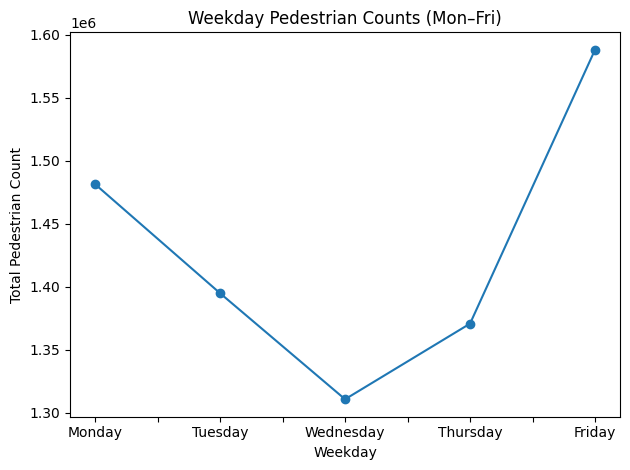

In [ ]:
df_wd = df.copy()
df_wd["weekday_num"] = df_wd["dt"].dt.weekday
df_wd = df_wd[df_wd["weekday_num"] < 5]

agg_wd = (df_wd
          .groupby("weekday", sort=False, observed=True)[BROOKLYN_COL]
          .sum()
          .reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]))

display(agg_wd.to_frame(name="total_count"))

plt.figure()
agg_wd.plot(kind="line", marker="o")
plt.title("Weekday Pedestrian Counts (Mon–Fri)")
plt.xlabel("Weekday")
plt.ylabel("Total Pedestrian Count")
plt.tight_layout()
plt.show()


## 2) Brooklyn Bridge in 2019: Weather Influence & Correlation Matrix

,Pedestrians,temperature,precipitation
Pedestrians,1.000,0.359,-0.105
temperature,0.359,1.000,0.002
precipitation,-0.105,0.002,1.000


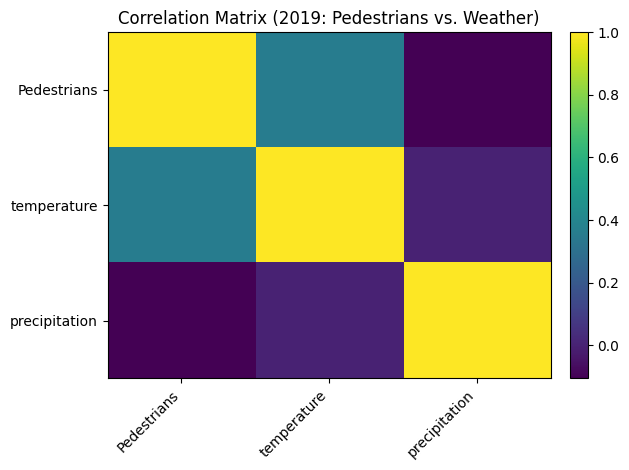

,count,sum,mean,median
weather_summary,,,,
partly-cloudy-day,1773,2790868,1574.093627,1632.0
clear-day,1413,1953025,1382.183298,1380.0
wind,4,2716,679.000000,403.0
cloudy,1813,984867,543.225041,122.0
rain,607,139502,229.822076,52.0
snow,38,8460,222.631579,29.5
fog,22,4673,212.409091,80.0
sleet,8,1426,178.250000,155.5
partly-cloudy-night,1209,63794,52.765922,10.0


In [ ]:
df_2019 = df[df["year"] == 2019].copy()
if df_2019.empty:
    raise ValueError("No rows for year 2019 in this dataset.")

if weather_summary_col is not None:
    df_2019_sorted = df_2019.sort_values(by=weather_summary_col)
else:
    df_2019_sorted = df_2019.copy()

num_cols = [BROOKLYN_COL] + weather_numeric_cols
num_cols = [c for c in num_cols if c in df_2019_sorted.columns]

if len(num_cols) >= 2:
    corr_df = df_2019_sorted[num_cols].corr(method="pearson")
    display(corr_df.round(3))

    plt.figure()
    im = plt.imshow(corr_df.values, aspect="auto")
    plt.xticks(ticks=np.arange(len(corr_df.columns)), labels=corr_df.columns, rotation=45, ha="right")
    plt.yticks(ticks=np.arange(len(corr_df.index)), labels=corr_df.index)
    plt.title("Correlation Matrix (2019: Pedestrians vs. Weather)")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()
else:
    print("Insufficient numeric weather columns for correlations in 2019.")

if weather_summary_col is not None:
    agg_weather = (df_2019_sorted
                   .groupby(weather_summary_col, observed=True)[BROOKLYN_COL]
                   .agg(["count", "sum", "mean", "median"])
                   .sort_values("mean", ascending=False))
    display(agg_weather)


## 3) Time-of-Day Categories: Morning / Afternoon / Evening / Night

,avg_count
time_of_day,
morning,529.699338
afternoon,1749.484305
evening,908.873318
night,50.086680


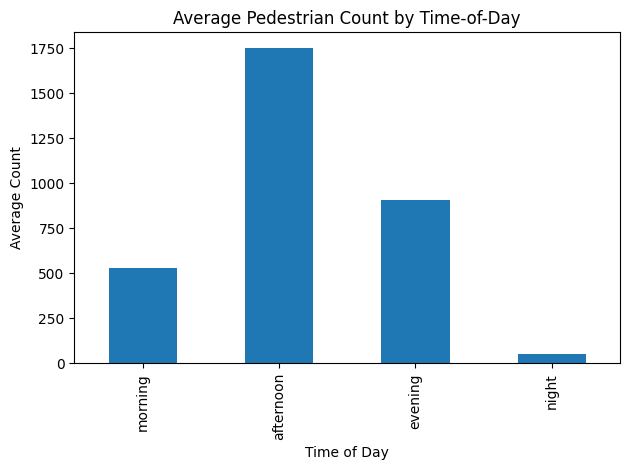

In [ ]:
df_tod = df.copy()
df_tod["time_of_day"] = df_tod["hour"].apply(time_of_day_category)

order = ["morning", "afternoon", "evening", "night"]
agg_tod = (df_tod
           .groupby("time_of_day", observed=True)[BROOKLYN_COL]
           .mean()
           .reindex(order))

display(agg_tod.to_frame(name="avg_count"))

plt.figure()
agg_tod.plot(kind="bar")
plt.title("Average Pedestrian Count by Time-of-Day")
plt.xlabel("Time of Day")
plt.ylabel("Average Count")
plt.tight_layout()
plt.show()
